In [2]:
path = 'data/GrowthProfilerResults_Long_Pretest.csv'

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# REad in long format dataframe (check function plot_growth_cruves for args)

df=pd.read_csv(path)

# remove D6 a none control that luckily doesn't overlap with other conditions as we onluse used a subset of wells
df = df[df['WellID'] != 'D6']


In [5]:
# Let's create a subset where every condition and media only has 3 reps

# This allows for tests that assume even variance (which is not necessarily what happens here just because we line up 3 reps per cond)
df_3reps = df[df['Replicate']<=3].copy()

In [6]:
# When more than 3 replicates, this script will keep the lowest 3 replicates so that all conditions have same # of replicates
# conversely you can just use the 1st 3 replicates df_3reps
# Step 1: Compute replicate SDs
replicate_sds = (
    df.groupby(['Condition', 'Media', 'Replicate'])['OD600']
    .std()
    .reset_index(name='Replicate_SD')
)

# Step 2: Count replicates per Condition × Media
rep_counts = (
    replicate_sds.groupby(['Condition', 'Media'])['Replicate']
    .count()
    .reset_index(name='Replicate_Count')
)

# Step 3: Merge SDs and replicate counts
replicate_sds = replicate_sds.merge(rep_counts, on=['Condition', 'Media'])

# Step 4: Mark which replicates to keep (top 3 if more than 3, else all)
replicate_sds['Keep'] = (
    replicate_sds
    .sort_values(['Condition', 'Media', 'Replicate_SD'])
    .groupby(['Condition', 'Media'])
    .cumcount() < 3
)

# Keep all if total replicates ≤ 3
replicate_sds['Keep'] = replicate_sds.apply(
    lambda row: True if row['Replicate_Count'] <= 3 else row['Keep'],
    axis=1
)

# Step 5: Filter original df using selected replicates
reps_to_keep = replicate_sds[replicate_sds['Keep']][['Condition', 'Media', 'Replicate']]



## variable where lowest sd triplicate is saved
df_3reps_low_sd = df.merge(reps_to_keep, on=['Condition', 'Media', 'Replicate']).copy()


In [7]:
# Count unique replicates per Media and Condition
# Useful check considering you might want to manipulate replicates/outliers or when some experiments/runs fail.

#df.groupby(['Condition', 'Media'])['Replicate'].nunique()
#df_3reps.groupby(['Condition', 'Media'])['Replicate'].nunique()
#df_3reps_low_sd.groupby(['Condition', 'Media'])['Replicate'].nunique()

In [8]:
def plot_growth_curves (df, x='Time', y='OD600', hue='Media', style='Condition', ci_level=95):

    """
    Plots growth curves with confidence intervals using seaborn.

    Parameters:
    - df: pandas DataFrame containing the data
    - x: column name for x-axis (default 'Time')
    - y: column name for y-axis (default 'OD600')
    - hue: column name for grouping by color (default 'Media')
    - style: column name for line style (default 'Condition')
    - ci_level: confidence interval level (default 95)
    """

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=x, y=y, hue=hue, style=style, errorbar =('ci', ci_level))
    plt.title(f'Growth curves by {hue} and {style} - CI({ci_level})')
    plt.ylabel(y)
    plt.xlabel(f'{x} (hours)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [9]:
def plot_growth_facets(df, condition_filter=None, col_wrap=2, ci_level='sd'):
    """
    Plots facet grid of growth curves across media, grouped by condition.

    Parameters:
    - df: DataFrame in long format
    - condition_filter: list of conditions to include
    - col_wrap: number of columns in FacetGrid layout
    - ci_level: confidence interval or 'sd' for standard deviation shading
    """
    subset = df.copy()
    
    if condition_filter is not None:
        subset = subset[subset['Condition'].isin(condition_filter)]

    g = sns.FacetGrid(
        data=subset,
        col='Media',
        hue='Condition',
        height=4,
        aspect=1.5,
        sharey=True,
        col_wrap=col_wrap
    )

    g.map_dataframe(
        sns.lineplot,
        x='Time',
        y='OD600',
        estimator='mean',
        errorbar=ci_level
    )

    g.add_legend(title='Condition')
    g.set_axis_labels("Time (hours)", "OD600")
    g.set_titles(col_template="{col_name}")
    g.fig.suptitle("Growth Comparison Across Media", fontsize=16, y=1.05)

    plt.tight_layout()
    plt.show()


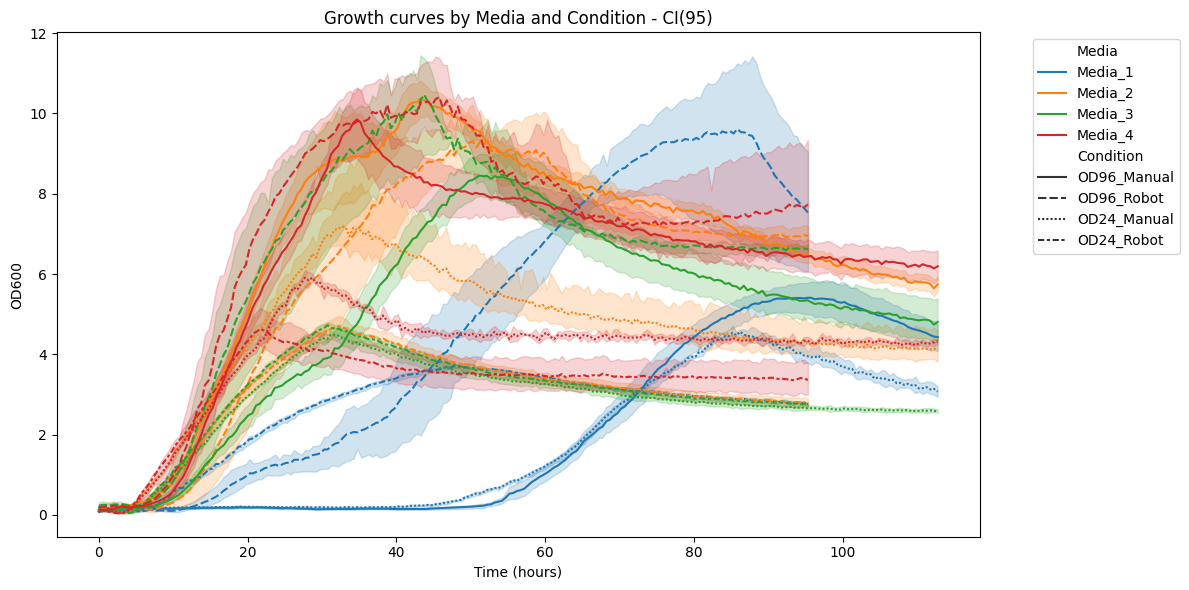

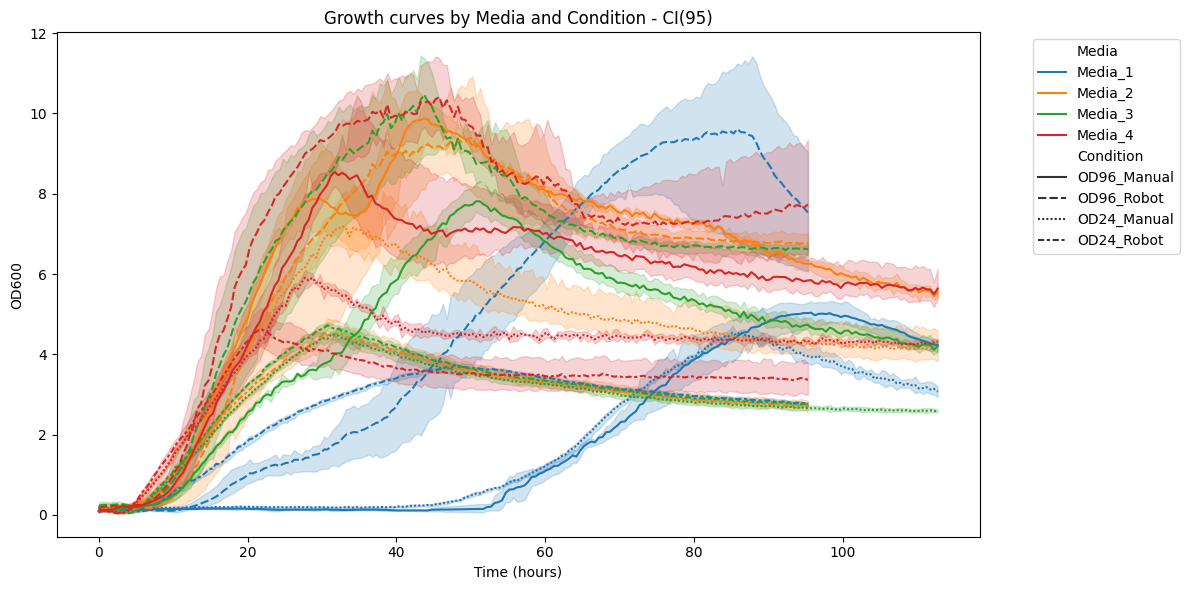

In [10]:
plot_growth_curves(df)


plot_growth_curves(df_3reps_low_sd)

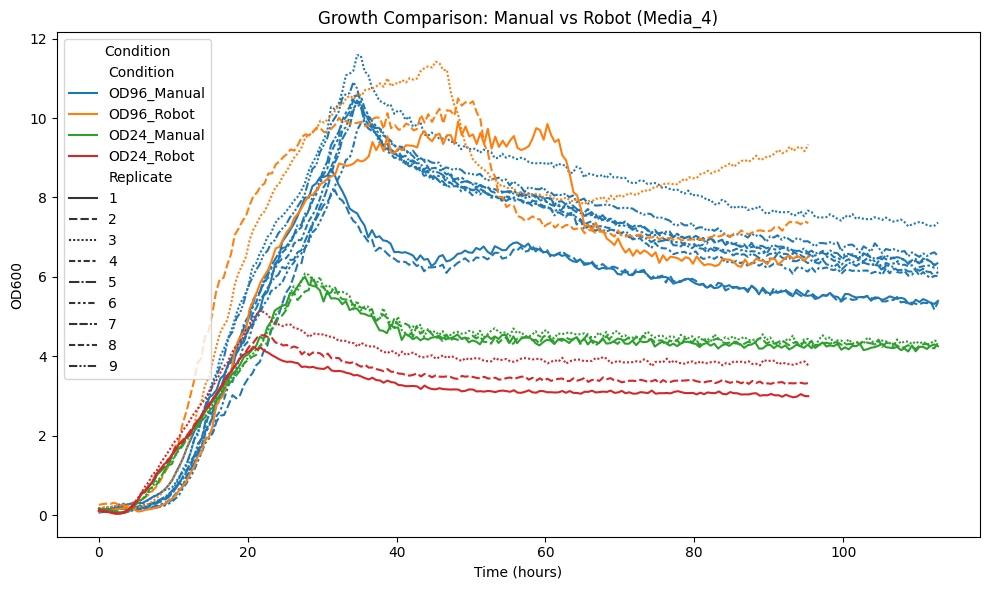

In [11]:
Media = 'Media_4'

subset = df[
    (df['Condition'].isin(['OD96_Manual', 'OD96_Robot', 'OD24_Manual', 'OD24_Robot'])) &
    (df['Media'] == Media)
]
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=subset,
    x='Time',
    y='OD600',
    hue='Condition',
    style='Replicate',
    markers=False,
    dashes=True,
    estimator=None,  # Keep all replicate lines
    units='Replicate'
)

plt.title(f'Growth Comparison: Manual vs Robot ({Media})')
plt.ylabel('OD600')
plt.xlabel('Time (hours)')
plt.legend(title='Condition')
plt.tight_layout()
plt.show()

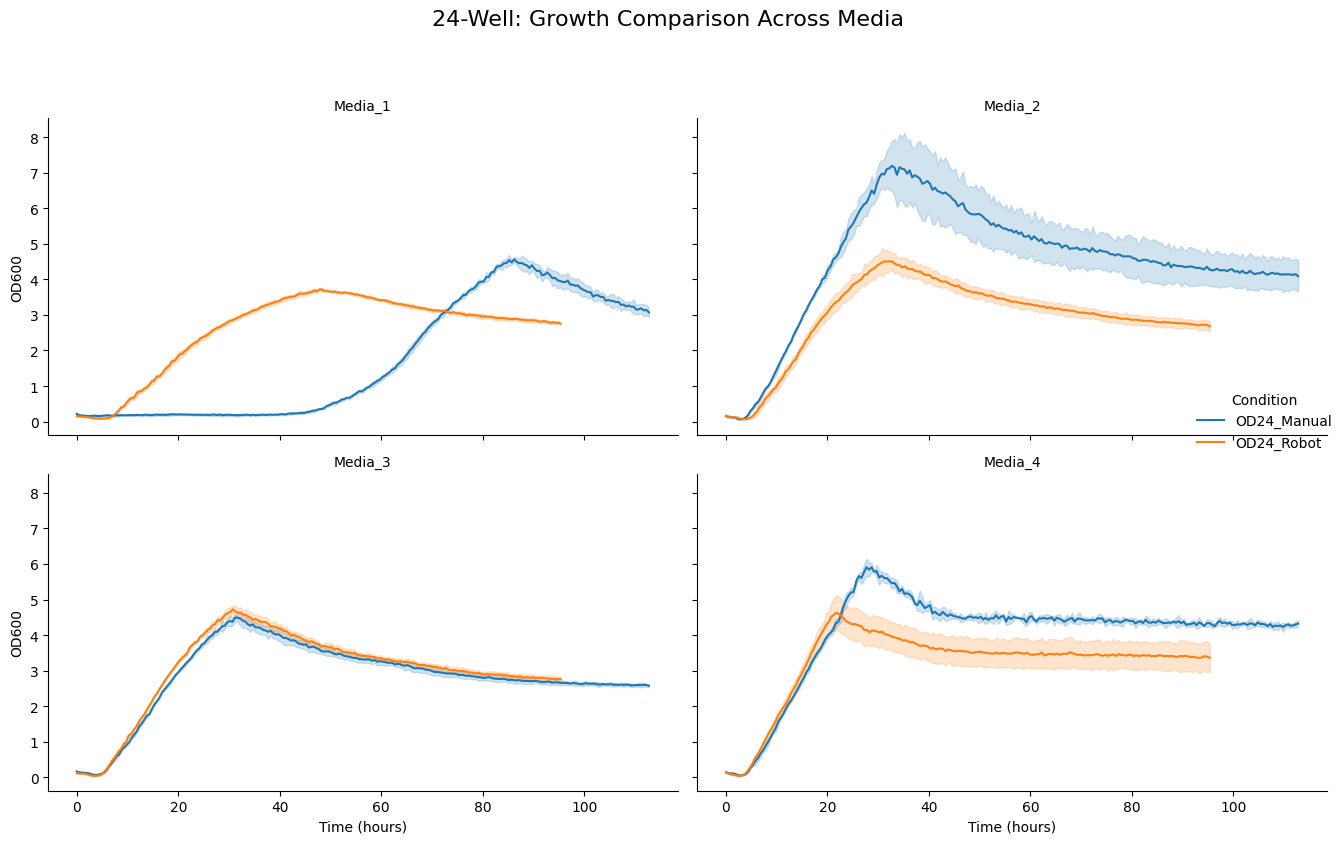

In [12]:
# Filter only the 24-well conditions
subset_24 = df_3reps_low_sd[df_3reps_low_sd['Condition'].isin(['OD24_Manual', 'OD24_Robot'])]

# Set up FacetGrid: one subplot per media
g = sns.FacetGrid(
    data=subset_24,
    col='Media',
    hue='Condition',
    height=4,
    aspect=1.5,
    sharey=True,
    col_wrap=2
)

# Map mean curves with SD shading
g.map_dataframe(
    sns.lineplot,
    x='Time',
    y='OD600',
    estimator='mean',
    errorbar='sd'  # Standard deviation shading
)

# Add legend and labels
g.add_legend(title='Condition')
g.set_axis_labels("Time (hours)", "OD600")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("24-Well: Growth Comparison Across Media", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()

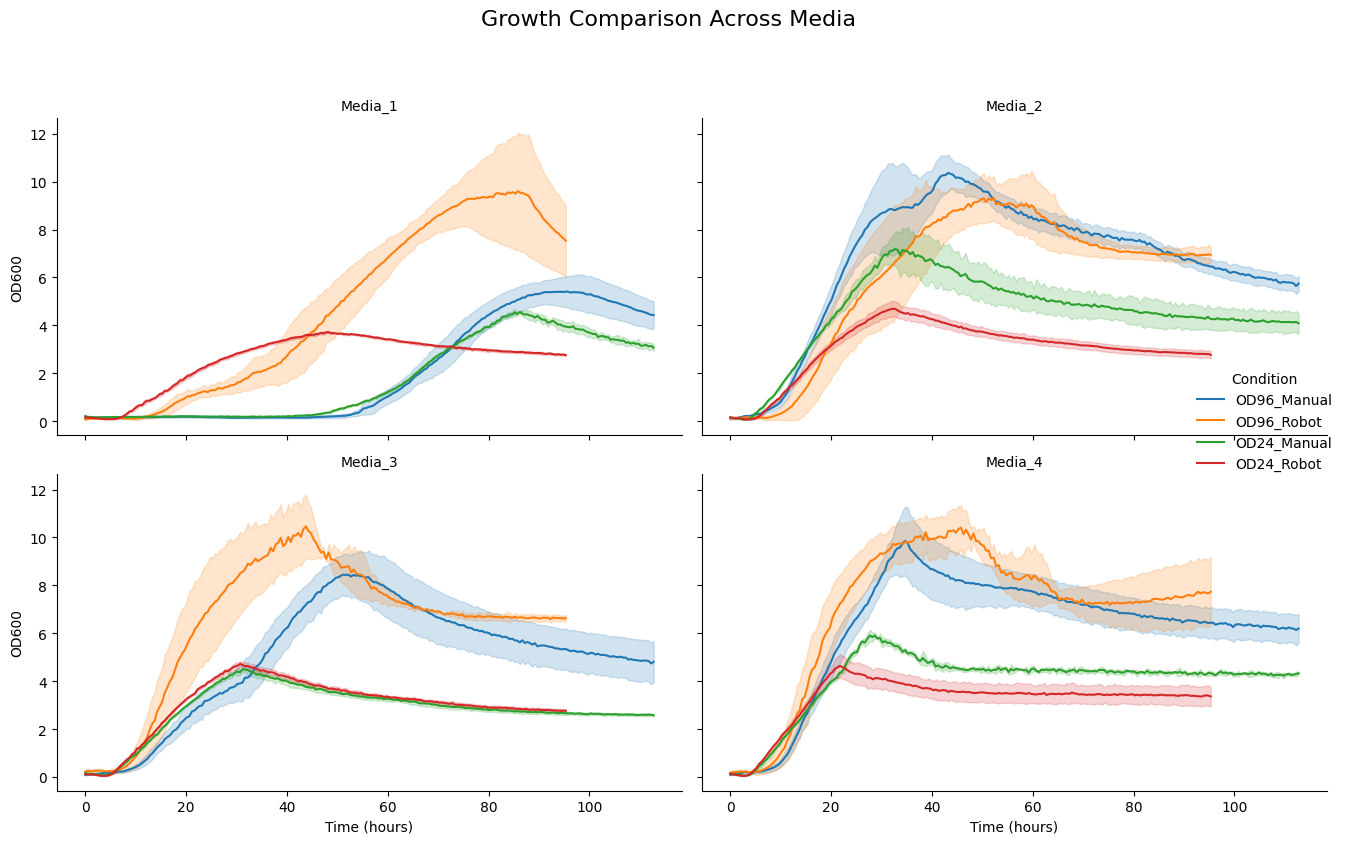

In [13]:
plot_growth_facets(df, condition_filter=['OD24_Manual', 'OD24_Robot', 'OD96_Manual', 'OD96_Robot'])
#plot_growth_facets(df_3reps, condition_filter=['OD24_Manual','OD24_Robot','OD96_Manual', 'OD96_Robot'])
#plot_growth_facets(df_3reps_low_sd, condition_filter=['OD24_Manual', 'OD24_Robot','OD96_Manual', 'OD96_Robot'])

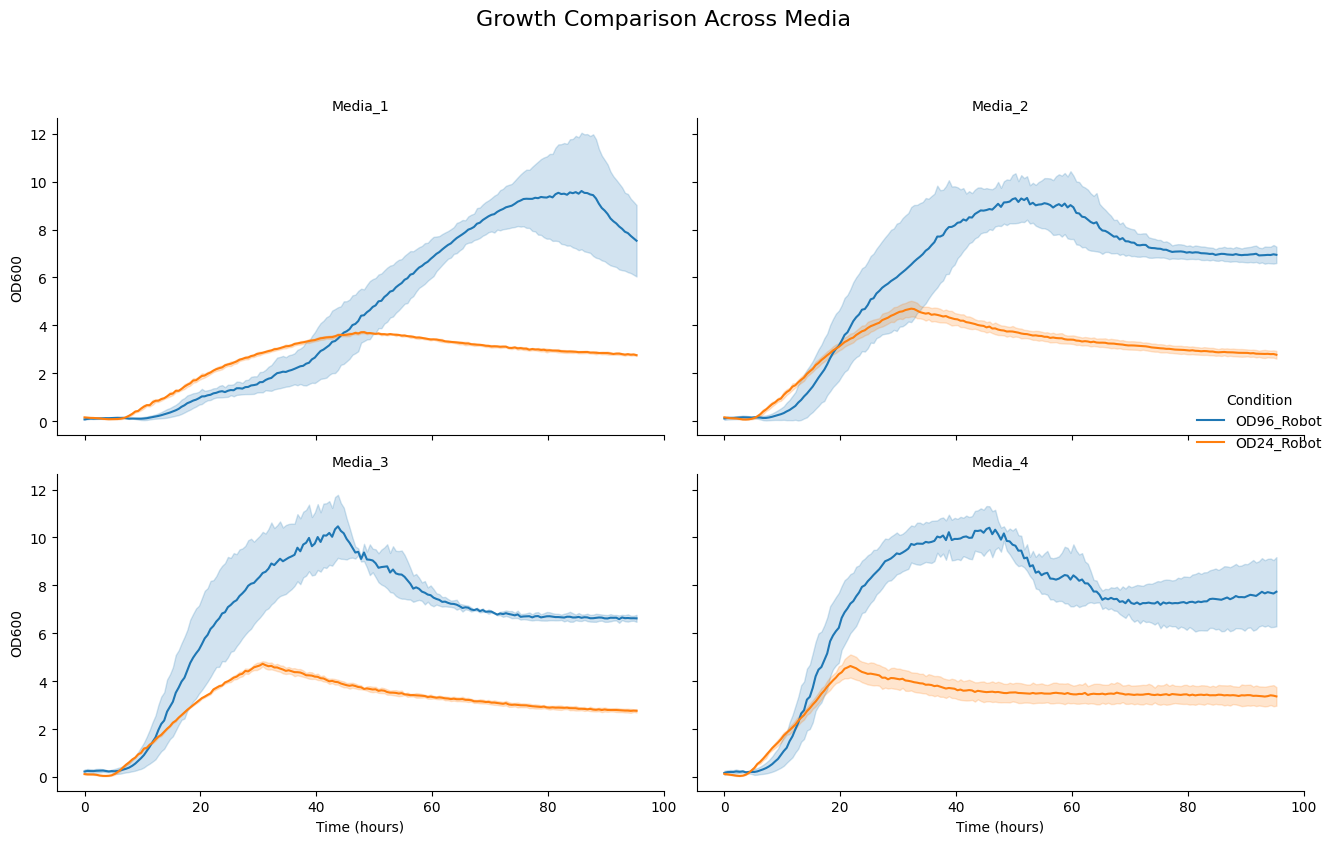

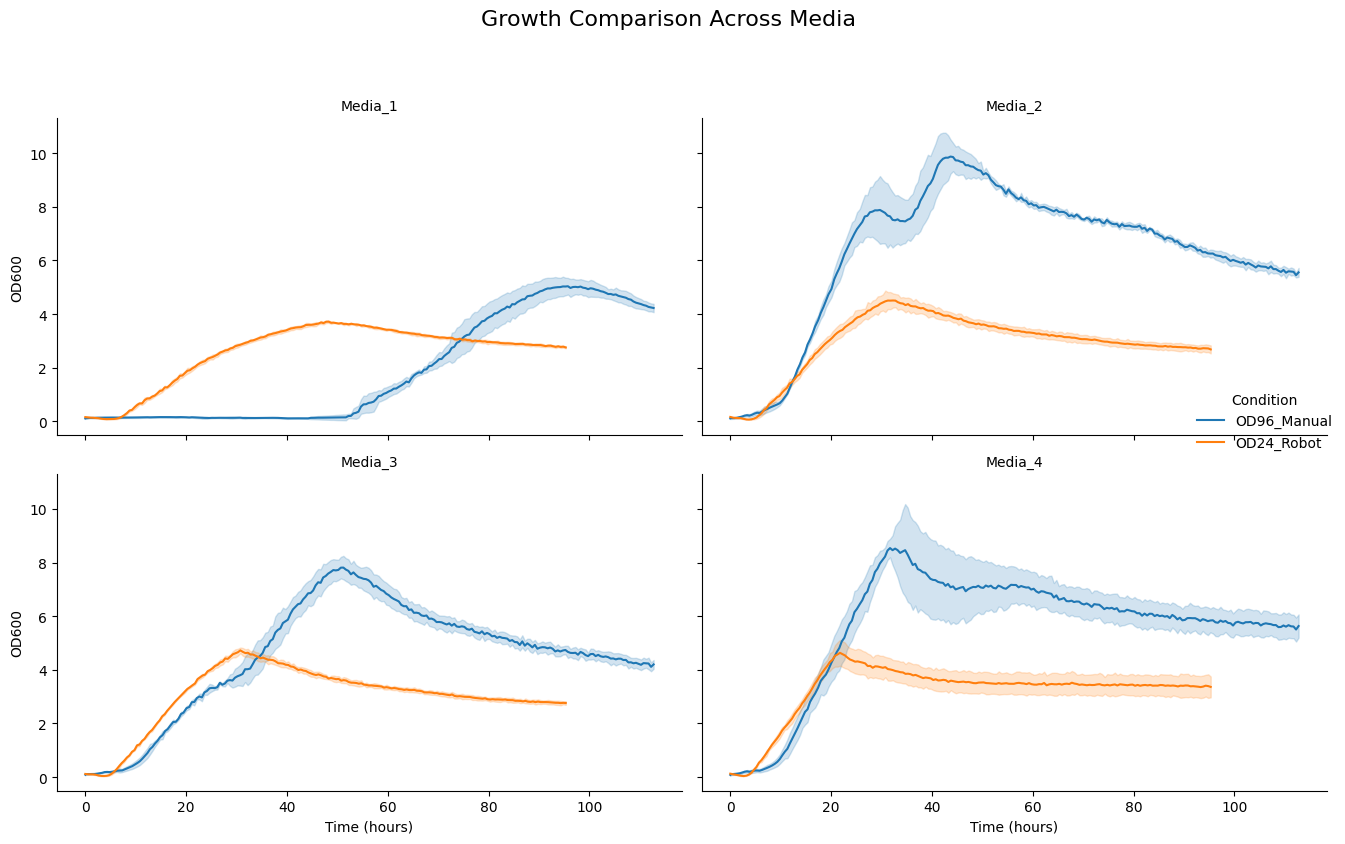

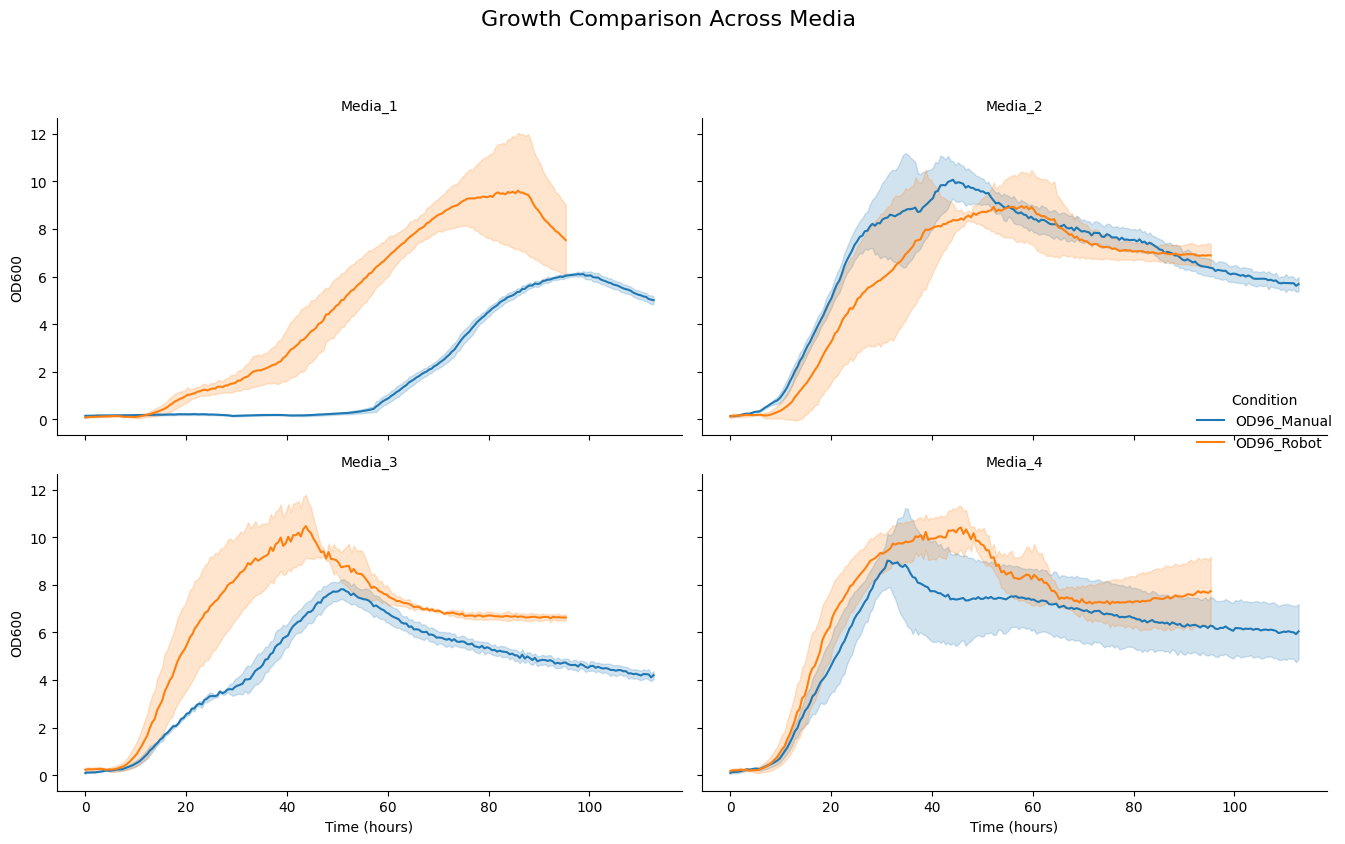

In [14]:
plot_growth_facets(df, condition_filter=['OD24_Robot', 'OD96_Robot'])
plot_growth_facets(df_3reps_low_sd, condition_filter=['OD24_Robot','OD96_Manual'])
plot_growth_facets(df_3reps, condition_filter=['OD96_Manual', 'OD96_Robot'])

In [15]:
from scipy.stats import levene

# Subset for one condition (e.g., OD96_manual)
subset = df[df['Condition'] == 'OD96_Manual']
groups = [group['OD600'].values for name, group in subset.groupby('Media')]

stat, p = levene(*groups)
print(f"Levene’s test: stat={stat:.3f}, p={p:.4f}")


Levene’s test: stat=8.289, p=0.0000


In [16]:
# next step on the Leven'e test


from scipy.stats import levene

# Subset the data for the corrected condition name
subset = df[df['Condition'] == 'OD96_Manual']

# Group by media and prepare sample lists
groups = [
    group['OD600'].dropna().values
    for _, group in subset.groupby('Media')
    if len(group['OD600'].dropna()) > 1
]

# Run Levene's test if we have at least two groups
if len(groups) >= 2:
    stat, p = levene(*groups)
    print(f"Levene’s test: stat={stat:.3f}, p={p:.4f}")
    if p < 0.05:
        print("⚠️ Variances are significantly different across groups — consider Welch's ANOVA.")
    else:
        print("✅ Variances appear equal — standard ANOVA is appropriate.")
else:
    print("❌ Not enough valid groups for Levene’s test.")


Levene’s test: stat=8.289, p=0.0000
⚠️ Variances are significantly different across groups — consider Welch's ANOVA.


In [17]:
# linear models or mixed models are more robust when n is unequal 

#This needs to be rewritten to consider time.

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

model = smf.ols('OD600 ~ Media + Condition + Media:Condition', data=df).fit()
anova_table = anova_lm(model, typ=2)
print(anova_table)

                       sum_sq       df            F         PR(>F)
Media            24516.921244      3.0  1477.990880   0.000000e+00
Condition        18505.835370      3.0  1115.615441   0.000000e+00
Media:Condition   6987.714266      9.0   140.417005  2.478897e-256
Residual         89464.644457  16180.0          NaN            NaN


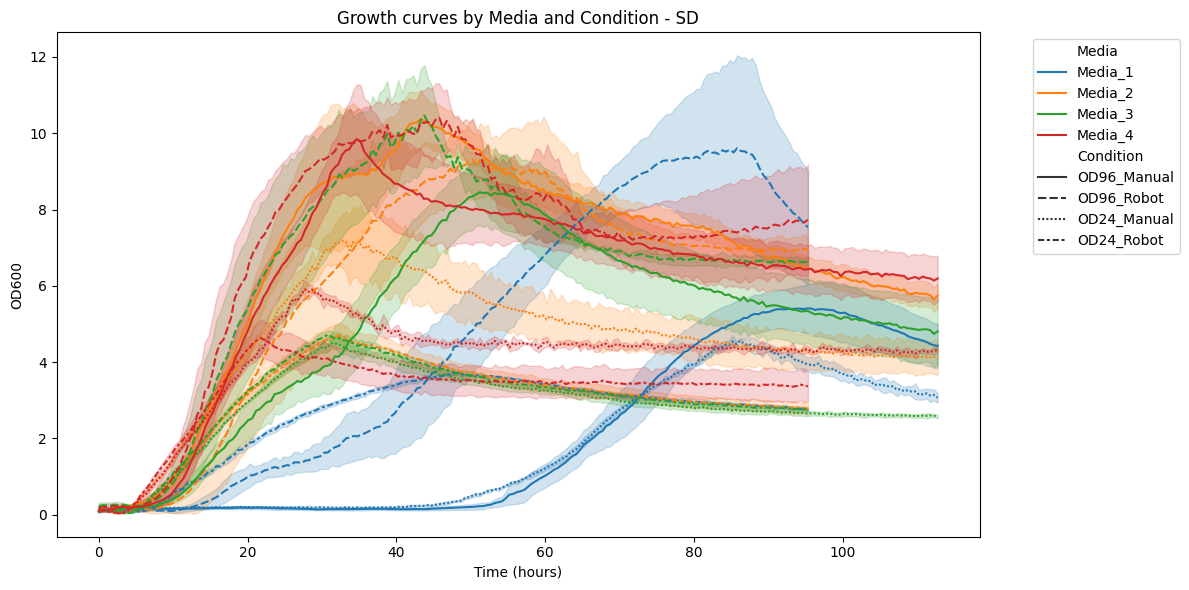

In [18]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Time', y='OD600', hue='Media', style='Condition', errorbar = 'sd') #errorbar='sd' or errorbar=('ci',95)
plt.title('Growth curves by Media and Condition - SD')
plt.ylabel('OD600')
plt.xlabel('Time (hours)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#===#

A two-way ANOVA was conducted to assess the effects of Media and Condition (a combined factor of timepoint and handling method) on final OD600. The analysis revealed significant main effects of both Media and Condition, though the interpretation of these effects is limited by the inclusion of timepoint in the Condition factor. As time strongly influences OD600, these results reflect combined differences in time, media composition, and handling method. Further analysis would be required to isolate the individual contribution of each factor.

In [19]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Just use final OD600 for this example
model_df = subset.copy()

# Convert to categorical
model_df['Media'] = model_df['Media'].astype('category')
model_df['Condition'] = model_df['Condition'].astype('category')

# Fit model
model = smf.ols('OD600 ~ Media + Condition + Media:Condition', data=model_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


ValueError: must have at least one row in constraint matrix

Main Effects:
Media: Highly significant (p < 0.001). There is strong evidence that OD600 significantly differs between different media.
Condition:Also highly significant (p < 0.001). This suggests the condition (e.g., drug treatment, environmental stress) has a strong effect on growth.
Interaction (Media:Condition):
Not significant (p = 0.428). This means that the effect of Condition on OD600 doesn’t significantly differ across Media types.
In other words, the effect of Condition appears to be consistent across different Media.

#===#

A Tukey HSD post-hoc test was conducted to determine which specific group means differed following a significant ANOVA result. The test revealed that:
Most comparisons between different Media, Conditions, and Timepoints were statistically significant (p < 0.05), confirming that both Media composition and experimental conditions significantly affect OD600.
For instance, Media_1_OD24_Manual differed significantly from Media_1_OD96_Robot (mean difference = 2.87, p < 0.001), indicating substantial growth over time and possibly the impact of robotic handling.
However, several group comparisons, such as Media_1_OD24_Robot vs. Media_3_OD24_Manual, showed no significant difference (p = 0.8944), suggesting that under some combinations, growth responses may be similar across media or methods.

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['OD600'], groups=df['Media'] + "_" + df['Condition'], alpha=0.05)
print(tukey.summary())


             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1              group2       meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------
Media_1_OD24_Manual  Media_1_OD24_Robot   0.8366    0.0  0.3794  1.2938   True
Media_1_OD24_Manual Media_1_OD96_Manual   0.3047 0.2042 -0.0526   0.662  False
Media_1_OD24_Manual  Media_1_OD96_Robot   2.8728    0.0  2.4156  3.3301   True
Media_1_OD24_Manual Media_2_OD24_Manual   2.7817    0.0  2.3441  3.2193   True
Media_1_OD24_Manual  Media_2_OD24_Robot   1.2964    0.0  0.8918  1.7011   True
Media_1_OD24_Manual Media_2_OD96_Manual   4.9287    0.0  4.5714  5.2861   True
Media_1_OD24_Manual  Media_2_OD96_Robot   4.2917    0.0  3.8871  4.6963   True
Media_1_OD24_Manual Media_3_OD24_Manual   1.0846    0.0   0.647  1.5222   True
Media_1_OD24_Manual  Media_3_OD24_Robot   1.2758    0.0  0.8185   1.733   True
Media_1_OD24_Manual Media_3_OD96_Manual   3.2349    

In [ ]:
import statsmodels.formula.api as smf

# Example: fit mixed model
# Assuming each unique replicate is identified (e.g., by combining Media + Replicate + Condition)

df['Subject'] = df['Media'] + "_" + df['Replicate'].astype(str) + "_" + df['Condition']

model = smf.mixedlm("OD600 ~ Time * Media * Condition", df, groups=df["Subject"])
result = model.fit()
print(result.summary())


                          Mixed Linear Model Regression Results
Model:                       MixedLM            Dependent Variable:            OD600      
No. Observations:            16196              Method:                        REML       
No. Groups:                  76                 Scale:                         3.3951     
Min. group size:             191                Log-Likelihood:                -33051.9183
Max. group size:             226                Converged:                     Yes        
Mean group size:             213.1                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
Intercept                                      -0.794    0.279  -2.846 0.004 -1.340 -0.247
Media[T.Media_2]          

Because the model to interpret broad trends across conditions (e.g., which condition has higher OD trajectory), not for fine time-dependent forecasting or pointwise prediction.
This model is quite valid as:
A screening tool to detect condition/media/time interaction effects
A high-level statistical summary of the growth dynamics
A way to compare trajectories across experimental setups
But it's not valid for:
Making time-step-specific inferences (e.g., predicting OD at t+1)
Modeling the detailed dynamics of microbial growth (e.g., fitting logistic or Gompertz curves)

Not to be used for prediction or forecasting, be cautious of interpreting p-values as exact.